In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader

from datetime import datetime
import numpy as np
from glob import glob
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from tensorboardX import SummaryWriter

In [3]:
IMG_DIR = 'data/flower_data/images/*'
LBL_DIR = 'data/flower_data/imagelabels.mat'

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 10
num_classes = 102
batch_size = 16
learning_rate = 0.001
num_imgs = 4

In [4]:
class Flowers102_Dataset(Dataset):
    def __init__(self, img_dir, lbl_dir, transform=None):
        self.img_glob = sorted(glob(img_dir))
        self.labels = loadmat(LBL_DIR)['labels'].squeeze()
        self.transform = transform
        self.classes = 'hi'
    def __len__(self):
        return len(self.img_glob)
    def __getitem__(self, idx):
        image = Image.open(self.img_glob[idx])
        # Classes must be zero indexed
        label = self.labels[idx]-1
        
        if self.transform:
            image = self.transform(image)
        return (image, label)

data_transform = transforms.Compose([
                 transforms.Resize(256),
                 transforms.CenterCrop(224),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

flower_dataset = Flowers102_Dataset(IMG_DIR, LBL_DIR, data_transform)
train_size = int(0.95*len(flower_dataset))
test_size = len(flower_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(flower_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

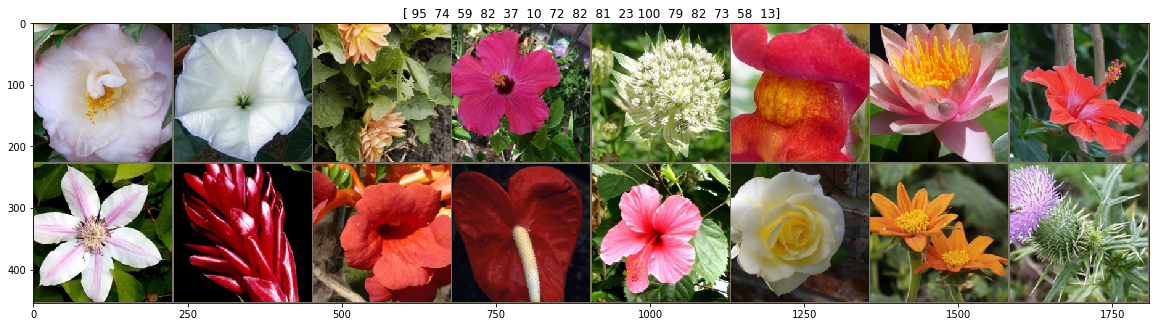

In [ ]:
def unnormalize(inp):
    # Unnormalize image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # Convert from tensor to PIL image
    inp = inp.numpy().transpose((1, 2, 0))
    inp = unnormalize(inp)
    plt.figure(figsize=(20,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = vutils.make_grid(inputs)

imshow(out, str(classes.numpy()))

In [ ]:
# Load Pretrained Network and Freeze Layers except final classifer layers
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Models to be tuned
[Pytorch Tutorial and Documentation on Finetuning](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)
set_parameter_requires_grad(resnet50, True)
resnet50.fc = nn.Linear(2048, num_classes)

alexnet = torchvision.models.alexnet(pretrained=True)
set_parameter_requires_grad(alexnet, True)
alexnet.classifier[6] = nn.Linear(4096,num_classes)


vgg11 = torchvision.models.vgg11_bn(pretrained=True)
set_parameter_requires_grad(vgg11, True)
vgg11.classifier[6] = nn.Linear(4096,num_classes)

squeezenet = torchvision.models.squeezenet1_0(pretrained=True)
set_parameter_requires_grad(squeezenet, True)
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
# because in forward pass, there is a view function call which depends on the final output class size.
squeezenet.num_classes = num_classes

densenet = torchvision.models.densenet121(pretrained=True)
set_parameter_requires_grad(densenet, True)
densenet.classifier = nn.Linear(1024, num_classes)

#'resnet50':resnet50, 'alexnet':alexnet, 'vgg11':vgg11,
models = { 'squeezenet':squeezenet, 'densenet':densenet}

In [ ]:
def tb_fig(tensor_batch, title=None):
    # Make a grid from batch
    out = vutils.make_grid(tensor_batch, )
    # Convert from tensor to PIL image
    inp = out.cpu().numpy().transpose((1, 2, 0))
    inp = unnormalize(inp)
    fig = plt.figure(figsize=(20,10))
    img = fig.add_subplot(1,1,1)
    if title is not None:
        img.set_title(title)
    img.imshow(inp)
    return fig

def train(data_loader, model, criterion, optimizer, epoch, train_step, device):
    model.train()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(data_loader):
        # Move
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Accuracy Measurement
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        acc =  (predicted == labels).sum().item() / labels.size(0)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            fig = tb_fig(images, "Label: "+str(labels.cpu().numpy())+'\n Preds: '+str(predicted.cpu().numpy()))
            writer.add_scalar('Train/Loss', loss.item(), train_step)
            writer.add_figure('Predictions/Train', fig, train_step)
            for name, param in model.named_parameters():
                writer.add_histogram(name, param.clone().cpu().data.numpy(), n_iter)
        train_step +=1
        
    total_acc = correct /total
    print (f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}")
    writer.add_scalar('Train/Accuracy', total_acc, train_step)
    return train_step

def test(data_loader, model, criterion, test_step, device):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Accuracy Measurement
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            acc =  (predicted == labels).sum().item() / labels.size(0)
            
            if i % 10 == 0:
                fig = tb_fig(images, "Labels: "+str(labels.cpu().numpy())+'\n Preds: '+str(predicted.cpu().numpy()))
                writer.add_scalar('Test/Loss', loss.item(), test_step)
                writer.add_figure('Predictions/Test', fig, test_step)
            test_step +=1
                
        total_acc = correct / total
        print(f'Test Accuracy of the model on the test images: {total_acc:.4f}')
        writer.add_scalar('Test/Accuracy', total_acc, test_step)
        
        return test_step

In [ ]:
print('Starting Training')
for name, model in models.items():
    # Tensorboard
    TB_NAME = 'runs/{0}: {1}'.format(name, datetime.now().strftime('%b%d_%H-%M-%S'))
    writer = SummaryWriter(log_dir=TB_NAME)
    train_step = 0
    test_step = 0
    
    model.to(device)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        train_step = train(train_loader, model, criterion, optimizer, epoch, train_step, device)
        test_step = test(test_loader, model, criterion, test_step, device)

Starting Training
Epoch [1/10], Step [487/487], Loss: 0.0888
Test Accuracy of the model on the test images: 0.8707
Epoch [2/10], Step [487/487], Loss: 0.0208
Test Accuracy of the model on the test images: 0.9171
Epoch [3/10], Step [487/487], Loss: 0.0029
Test Accuracy of the model on the test images: 0.9195
Epoch [4/10], Step [487/487], Loss: 0.0103
Test Accuracy of the model on the test images: 0.9146
Epoch [5/10], Step [487/487], Loss: 0.0102
Test Accuracy of the model on the test images: 0.9415
Epoch [6/10], Step [487/487], Loss: 0.0460
Test Accuracy of the model on the test images: 0.9220
